In [1]:
import os
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [3]:
# Import data
from os.path import dirname, join
from pathlib import Path
# ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root 
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
print(data_PATH)
# input data
data_raw = pd.read_csv(data_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\data\room_info.csv


In [4]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other","Elevated"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "Attic" : "Storage",
    "Office" : "Room",
    "TechnicalRoom":"Utility",
    "DraughtLobby" : "Entry",
    "Hall" : "Entry",
    "Basement" : "Storage"
}

data_raw["type_cleaned"] = data_raw["type"].apply(lambda x: merge.get(x,x))
data_raw["exclude"] = ~data_raw["type"].isin(exclusion)
# Excluding no-use features
data_cleaned = data_raw[~data_raw["type"].isin(exclusion)]
# Head view of the dataset
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")


,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [5]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = ['type_cleaned']
tier_spc = []
tier_con = ['type_cleaned']
for col in data_cleaned.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)
col_select = {
    'tierA' : tier_fur,
    'tierB' : tier_con,
    'tierC' : tier_spc
            } 
#Creating sub-datasets for each tier : tier1) furniture characteristics tier2) fur + connectivity tier 3) whole dataset
data_tier1a = pd.DataFrame(data_cleaned[col_select['tierA']])
data_tier1b = pd.DataFrame(data_cleaned[col_select['tierB']])
data_tier1c = pd.DataFrame(data_cleaned[col_select['tierC']])
data_tier2 = data_tier1c.copy()
data_tier2[col_select['tierB']] = data_tier1b
# quick view of the dataset grouped by type
# data_tier2.groupby('type_cleaned').count().sort_values('path', ascending= False)

# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
# colUniq(data_tier2)

In [6]:
# Normalizing Confusion Matrix
def matNorm (rawMat):
    test_m = rawMat.copy()
    row_sums = test_m.sum(axis=1)
    new_matrix = test_m / row_sums[:, np.newaxis]
    return new_matrix

#Results Path -------------

In [7]:
res_PATH = join(ROOT_DIR[:-16],"CSV")
print(res_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\CSV


### TIER 1 --------------------

In [8]:
#TIER 1) ------------------Group C-----------------------

#Defining Train and Target data
X = data_tier1c.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier1c.columns], axis =1)
y = data_tier1c['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, stratify=y)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2, stratify=y_train)

In [9]:
# Instanciate randomforest classifier 
model_1 = RandomForestClassifier(n_estimators= 1000,
                                criterion='gini',
                                random_state= 27
                                )
model_1

RandomForestClassifier(n_estimators=1000, random_state=27)

In [10]:
# train model 
model_1.fit(X_train_train,y_train_train)

RandomForestClassifier(n_estimators=1000, random_state=27)

In [11]:
train_score = model_1.score(X_train_train,y_train_train)
print("Tier 1C Training score: ",train_score)

Tier 1C Training score:  1.0


In [12]:
# predict
y_pred1 = model_1.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.89%


In [13]:
# Report Classification Results
file_name = "RndmFrst_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred1,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred1))


              precision    recall  f1-score   support

        Bath       0.80      0.84      0.82      2187
     Bedroom       0.77      0.91      0.84      2398
     CarPort       0.82      0.54      0.65        84
      Closet       0.65      0.62      0.64       912
      Dining       0.72      0.65      0.68       286
       Entry       0.87      0.92      0.89      1815
      Garage       0.65      0.72      0.68       124
     Kitchen       0.86      0.86      0.86      1364
  LivingRoom       0.78      0.87      0.82      1328
     Outdoor       0.94      0.97      0.96      2356
        Room       0.46      0.06      0.11       635
     Storage       0.68      0.62      0.65       586
     Utility       0.61      0.32      0.42       447

    accuracy                           0.81     14522
   macro avg       0.74      0.68      0.69     14522
weighted avg       0.79      0.81      0.79     14522



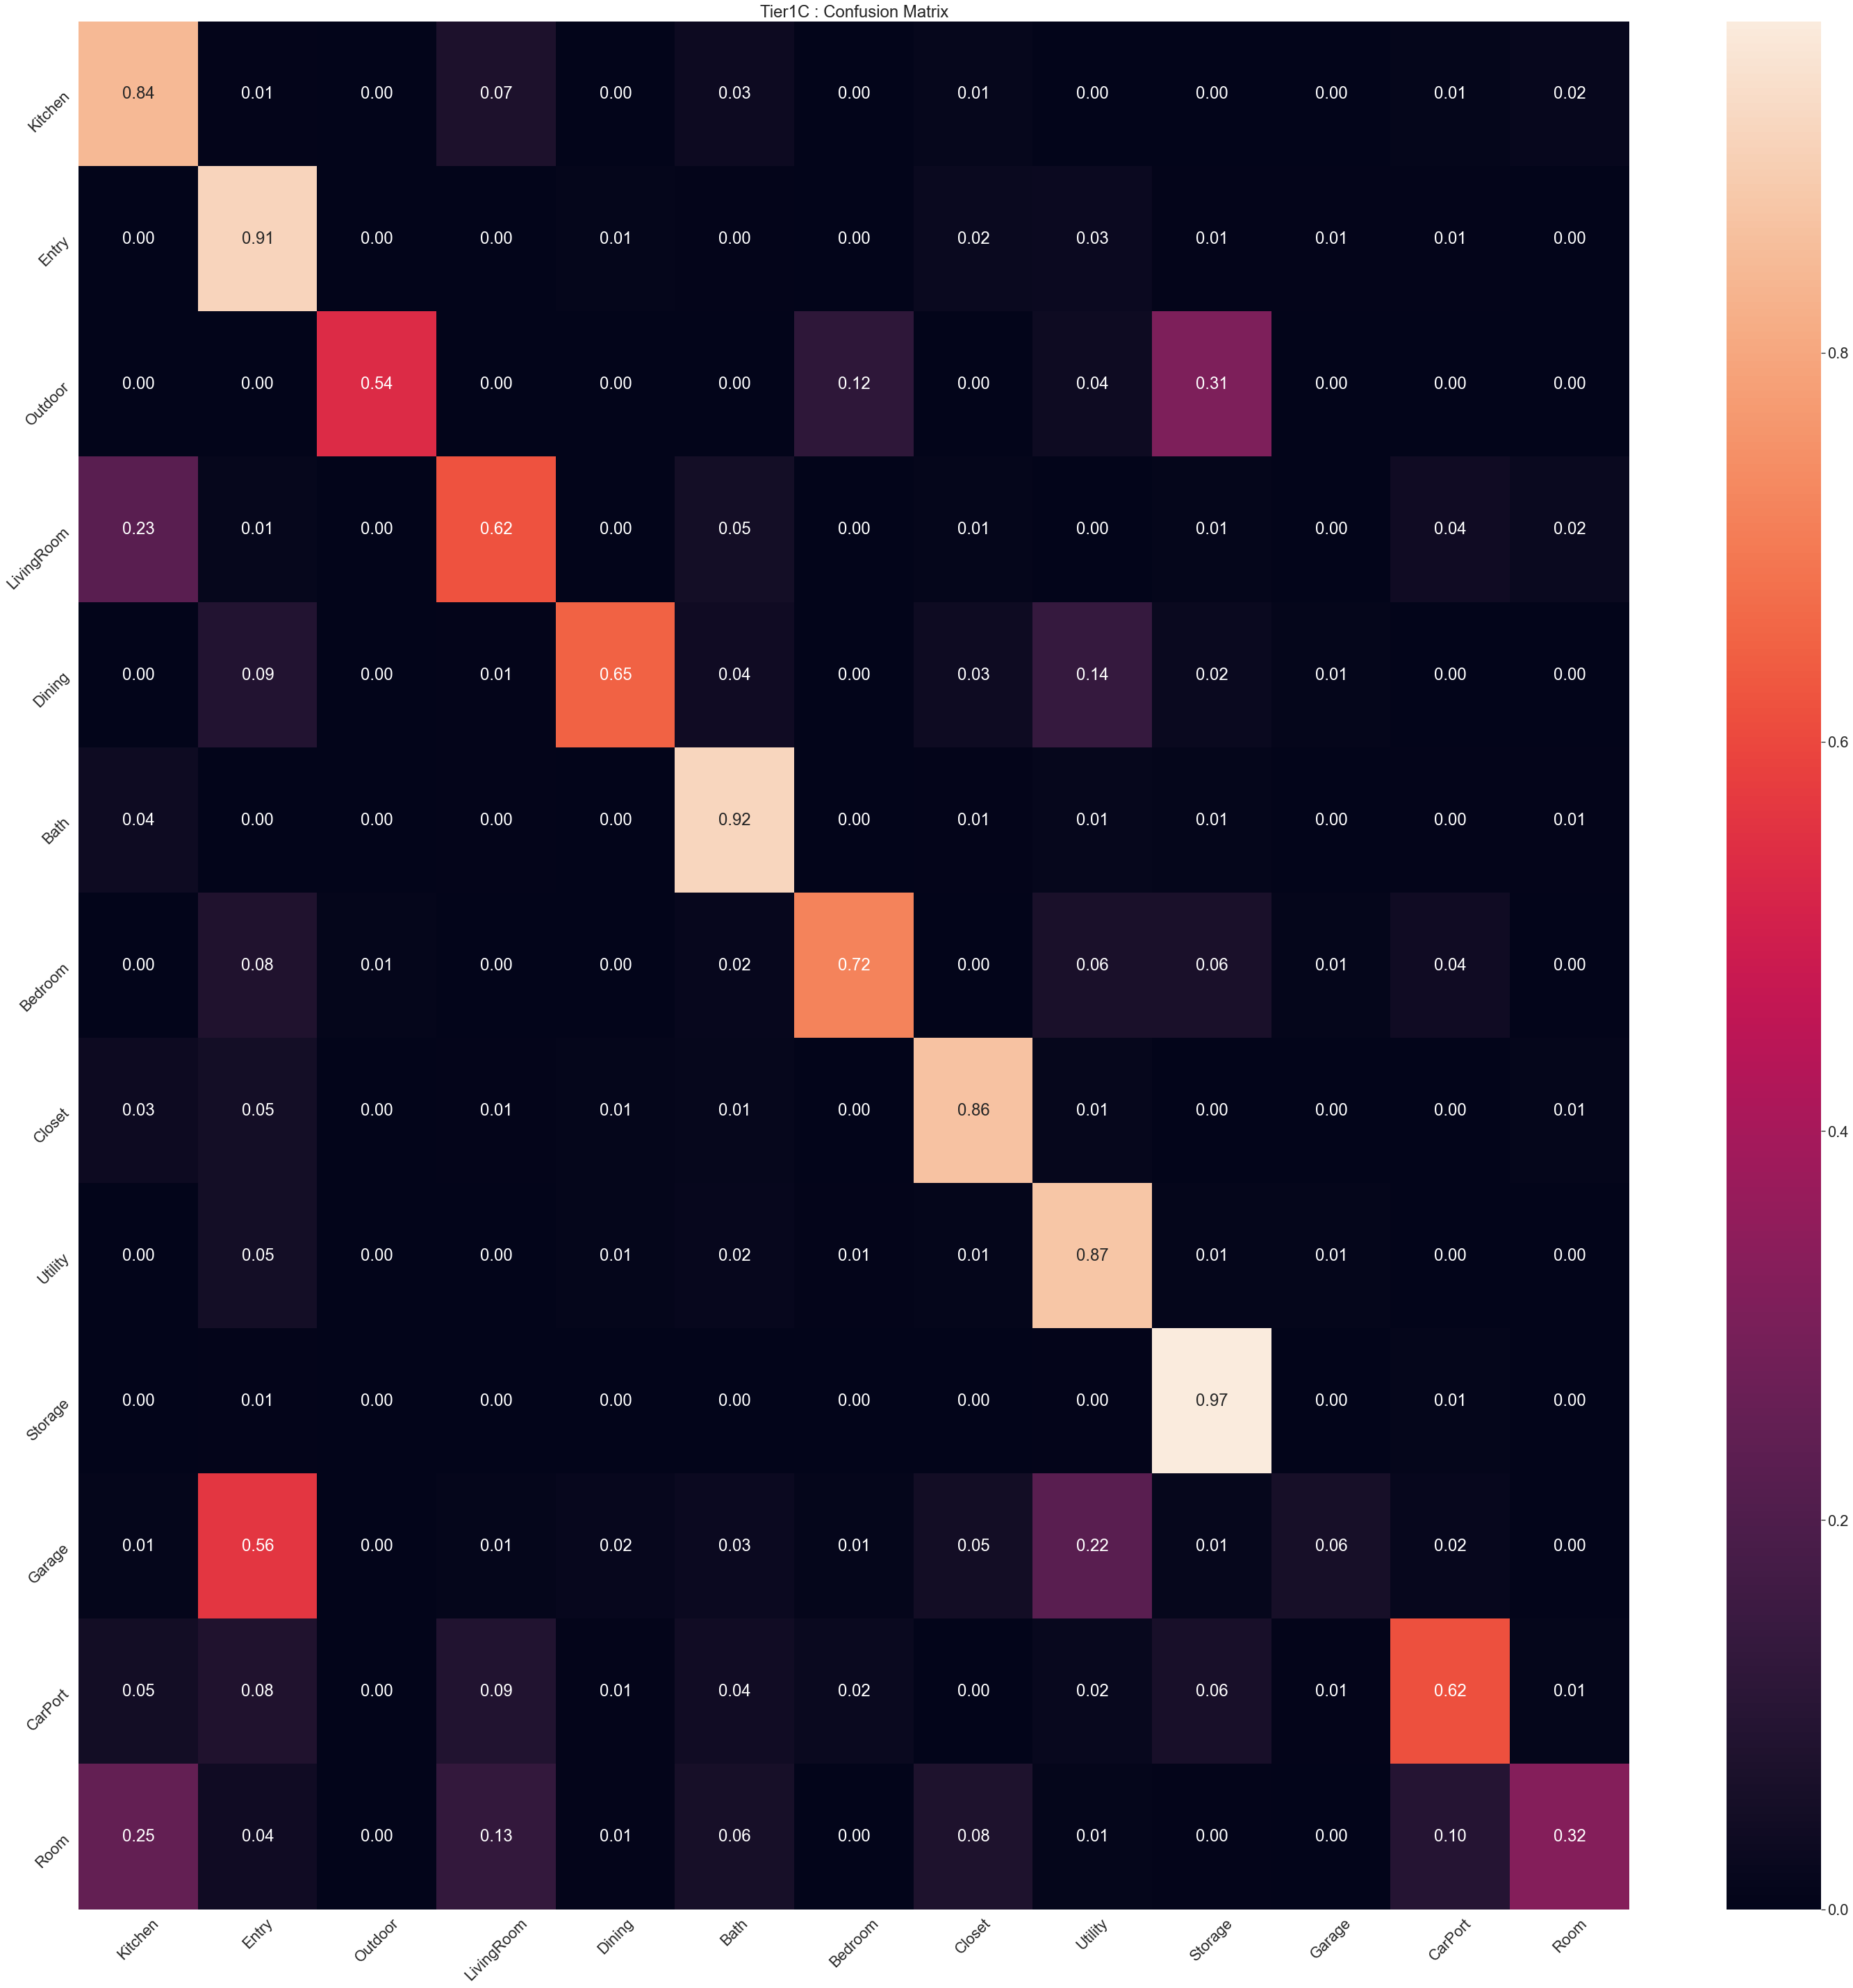

In [15]:
file_name = "RndmFrst_Tier1C_classificationReport.csv"
fig_PATH = join(res_PATH,file_name)
fig_PATH = join(res_PATH,"Tier1C_ConfMat.png")
cMat = confusion_matrix(y_test,y_pred1)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred1).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Tier1C : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=150)
plt.show()

In [81]:
# Feature importance
shap_values = shap.TreeExplainer(model_1).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model_1.classes_, title='RandomForest Feature Importance', color = plt.get_cmap("tab20b"))
plt.show()

### 2. GRID SEARCH on Tier 1

In [ ]:
# param_grid = {'n_estimators': [500, 1000,2000], 'class_weight':["balanced","balanced_subsamples"], 'oob_score': [False,True]}
# # scoring = {
#     # 'Percision': make_scorer(average_precision_score),
#     # 'f1': make_scorer(f1_score),
#     # 'Accuracy': make_scorer(accuracy_score),
#     # 'Recall': make_scorer(recall_score) }
# rfc_grid = RandomForestClassifier()
# grid_search = GridSearchCV(rfc_grid, param_grid, cv=5 , scoring='f1_macro' , return_train_score=True, refit='f1')
# grid_search.fit(X_train, y_train)
# cv_res = grid_search.cv_results_